<a href="https://colab.research.google.com/github/melbin97/google_colab/blob/master/sentimental_analysis_playstore_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install qq transformers

     |████████████████████████████████| 890kB 2.8MB/s 
     |████████████████████████████████| 890kB 15.9MB/s 
     |████████████████████████████████| 3.0MB 19.5MB/s 
     |████████████████████████████████| 1.1MB 38.4MB/s 
  Created wheel for qq: filename=qq-1.0.0-cp36-none-any.whl size=1168 sha256=2f6b483c70a433465a69e3d1e47bde3aa3bc976beb643875b4493044f523efe1
  Stored in directory: /root/.cache/pip/wheels/e7/f7/fd/2d6d587443f45cf43055826e29401c2acb2a1b3dfc9b79b94d
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=0d4eba389ee5273321953fad13e202fa4b4d84d80359baec9dffa4f7ffe05b2c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built qq sacremoses


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer,AdamW,get_linear_schedule_with_warmup
import torch

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
HAPPY_COLORS_PALETTE=["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

In [ ]:
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [ ]:
rcParams['figure.figsize']=12,8

In [ ]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 49.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 113MB/s]


In [ ]:
df=pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [ ]:
df.shape

(15746, 11)

In [ ]:
df.info

<bound method DataFrame.info of                 userName  ...              appId
0          Andrew Thomas  ...          com.anydo
1           Craig Haines  ...          com.anydo
2          steven adkins  ...          com.anydo
3       Lars Panzerbjørn  ...          com.anydo
4          Scott Prewitt  ...          com.anydo
...                  ...  ...                ...
15741          Tammy Kay  ...  com.appxy.planner
15742          Ysm Johan  ...  com.appxy.planner
15743      casey dearden  ...  com.appxy.planner
15744     Jerry G Tamate  ...  com.appxy.planner
15745  Ahmed elsalamouni  ...  com.appxy.planner

[15746 rows x 11 columns]>

Text(0.5, 0, 'review score')

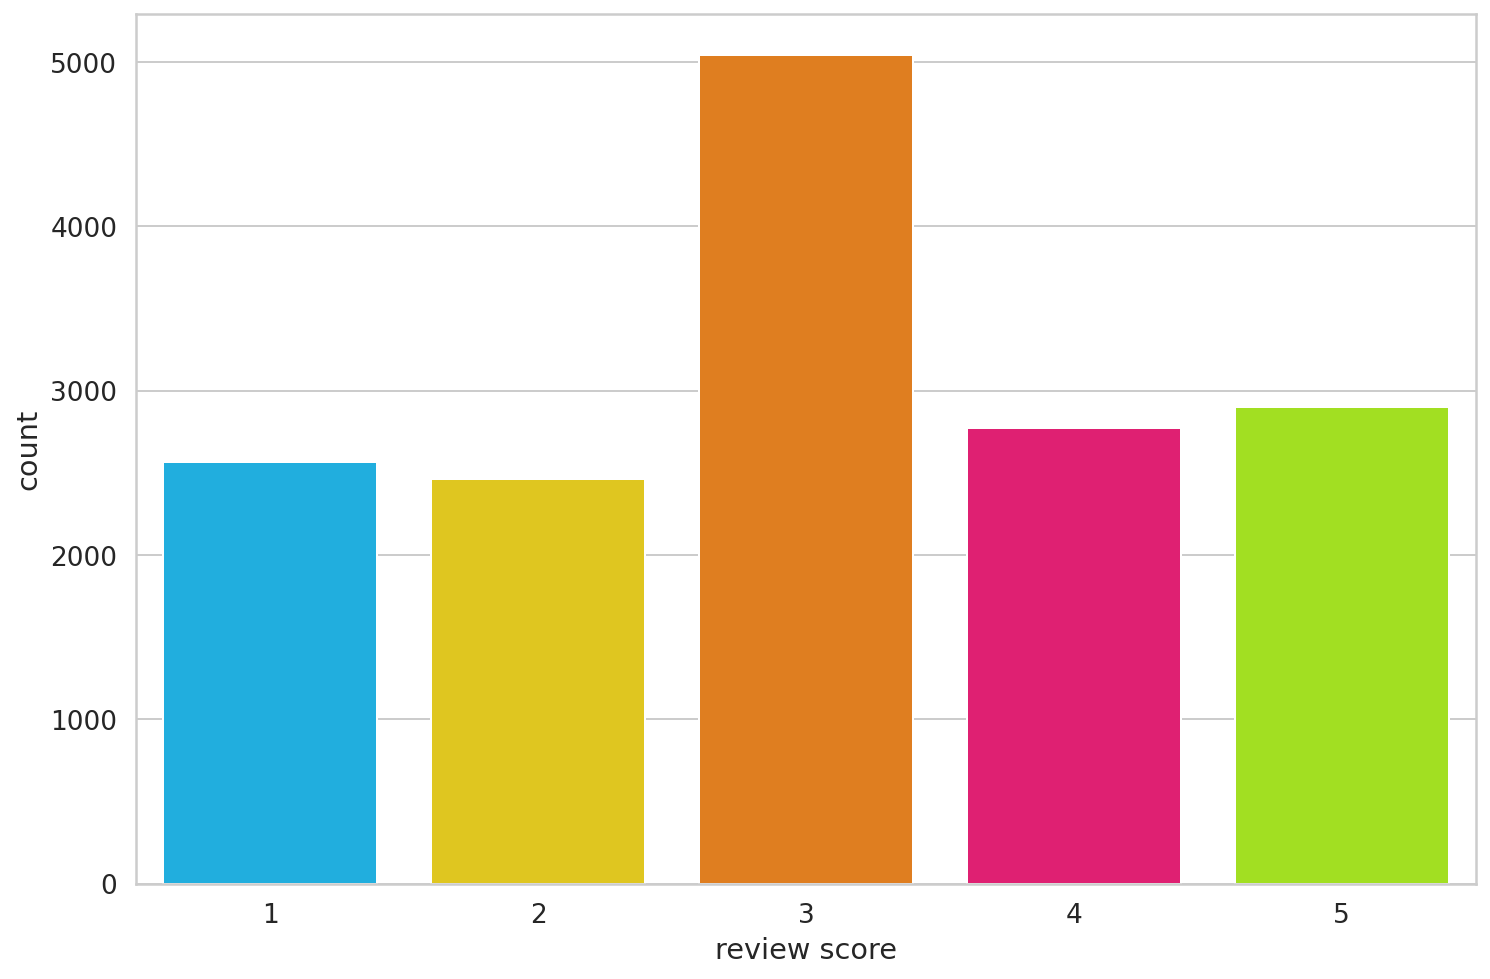

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score')

In [ ]:
def to_sentiment(rating):
  rating=int(rating)
  if rating<=2:
    return 0
  elif rating==3:
    return 1
  else:
    return 2

In [ ]:
df['sentiment']=df.score.apply(to_sentiment)
class_names=['negative','neutral','positive']

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

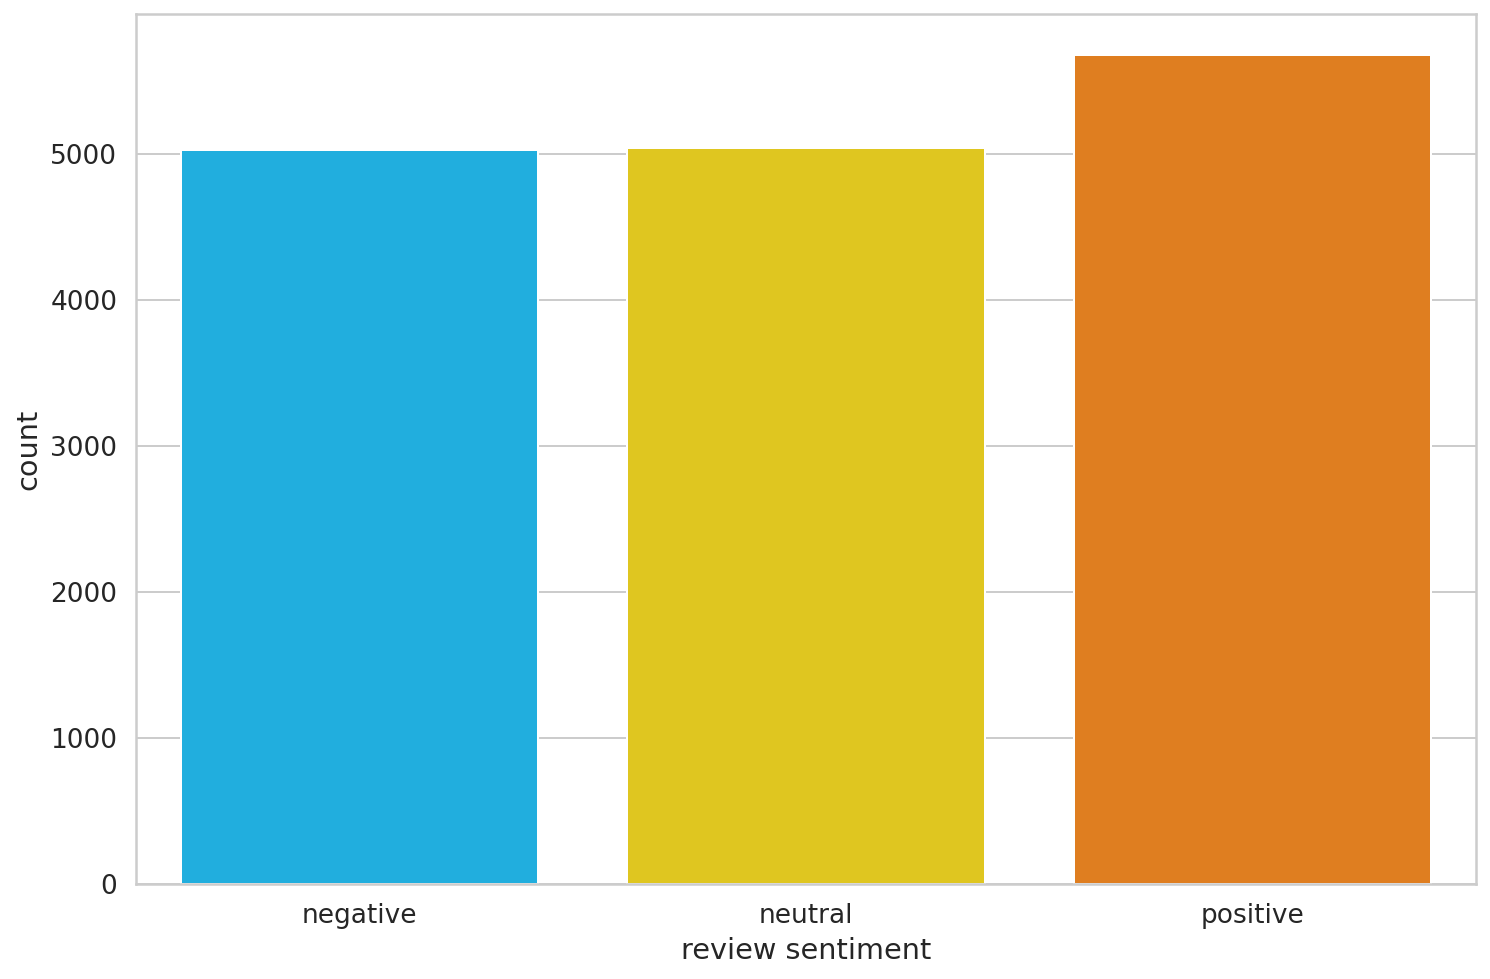

In [ ]:
ax=sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

In [ ]:
PRE_TRAINED_MODEL_NAME='bert-base-cased'

In [ ]:
tokenizer=BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt='when was i last outside? I am stuck at home for two months.'

In [ ]:
tokens=tokenizer.tokenize(sample_txt)
token_ids=tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token Ids: {token_ids}')

 Sentence: when was i last outside? I am stuck at home for two months.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', 'two', 'months', '.']
Token Ids: [1165, 1108, 178, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 1160, 1808, 119]


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token,tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token,tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token,tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
encoding=tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding=True,
    return_attention_mask=True,
    return_tensors='pt',
    truncation=True
)
encoding.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1165, 1108,  178, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111, 1160, 1808,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'when',
 'was',
 'i',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 'two',
 'months',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
token_lens=[]
for txt in df.content:
  tokens=tokenizer.encode(txt,max_length=512,truncation=True)
  token_lens.append(len(tokens))


Text(0.5, 0, 'Token Count')

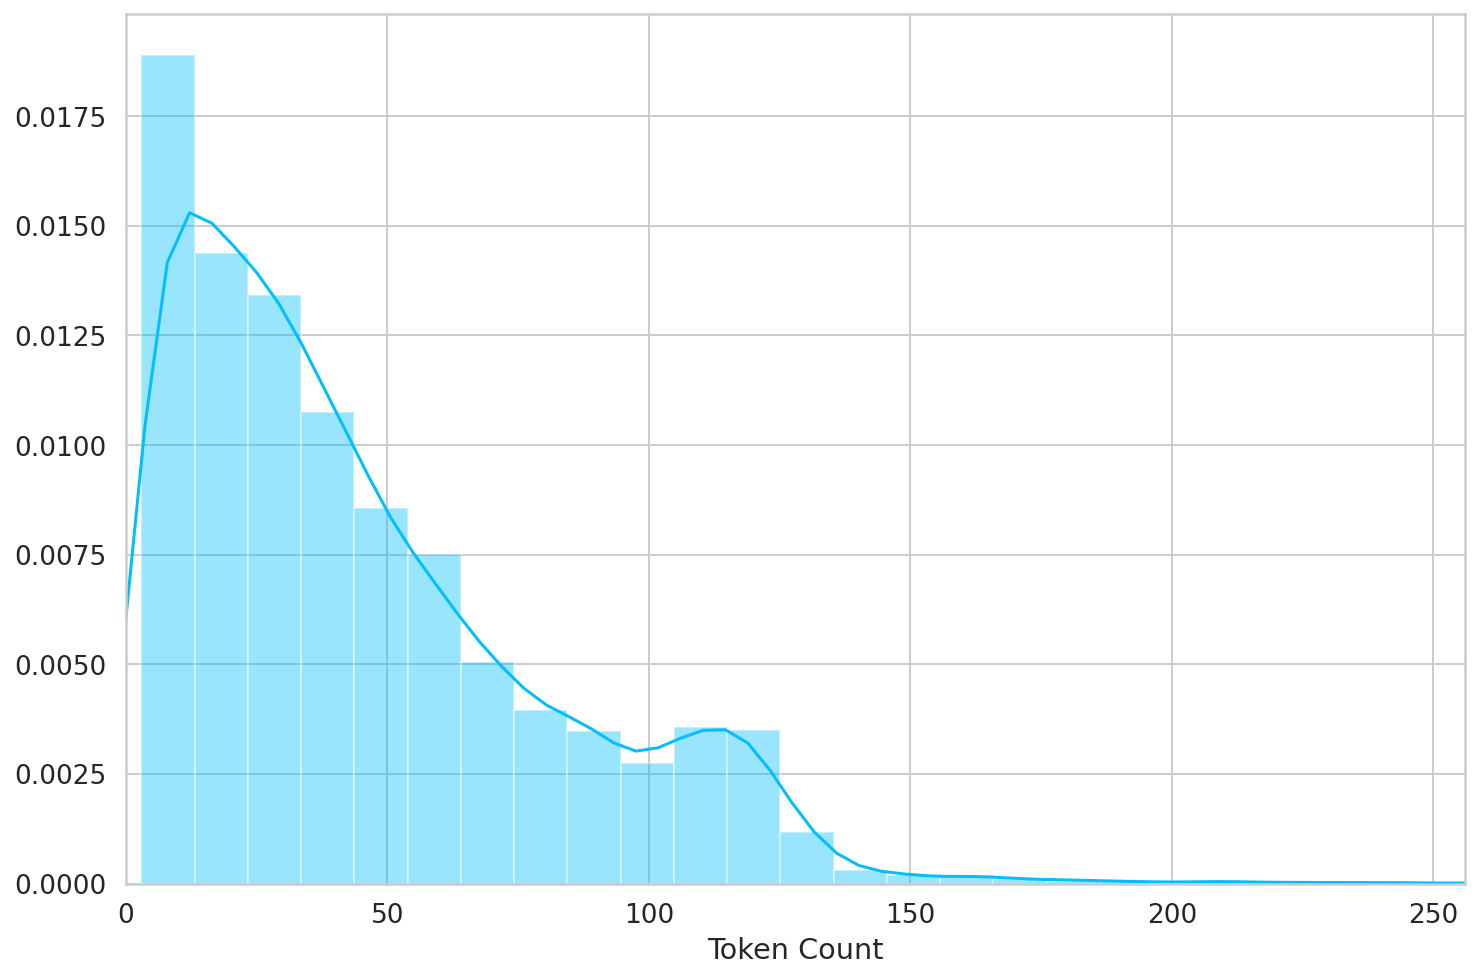

In [ ]:
sns.distplot(token_lens)
plt.xlim([0,256])
plt.xlabel('Token Count')

In [ ]:
MAX_LEN=160

In [ ]:
class GPReviewDataset(Dataset):
    def __init__(self,reviews,targets,tokenizer,max_len):
        self.reviews=reviews
        self.targets=targets
        self.tokenizer=tokenizer
        self.max_len=max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self,item):
        review=str(self.reviews[item])
        target=self.targets[item]
        encoding=self.tokenizer.encode_plus(
        review,
        truncation=True,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding=True,
        return_attention_mask=True,
        return_tensors='pt'
        )
        return {
        'review_text': review,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target,dtype=torch.long)
        }
    

In [ ]:
df_train,df_test=train_test_split(df,test_size=0.1,random_state=RANDOM_SEED)
df_val,df_test=train_test_split(df_test,test_size=0.5,random_state=RANDOM_SEED)

In [ ]:
df_train.shape,df_val.shape,df_test.shape

((14171, 12), (787, 12), (788, 12))

In [ ]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds=GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [ ]:
BATCH_SIZE=16
train_data_loader=create_data_loader(df_train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader=create_data_loader(df_val,tokenizer,MAX_LEN,BATCH_SIZE)
test_data_loader=create_data_loader(df_test,tokenizer,MAX_LEN,BATCH_SIZE)

In [ ]:
data=next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
bert_model=BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hiddent_state,pooled_output=bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

In [ ]:
last_hiddent_state.shape
bert_model.config.hidden_size
pooled_output.shape

torch.Size([1, 768])

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self,n_classes):
        super(SentimentClassifier,self).__init__()
        self.bert=BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop=nn.Dropout(p=0.3)
        self.out=nn.Linear(self.bert.config.hidden_size,n_classes)
    def forward(self,input_ids,attention_mask):
        _,pooled_output=self.bert(input_ids=input_ids,attention_mask=attention_mask)
        output=self.drop(pooled_output)
        return self.out(output)

In [ ]:
model=SentimentClassifier(len(class_names))
model=model.to(device)

In [ ]:
input_ids=data['input_ids'].to(device)
attention_mask=data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)
torch.Size([16,160])
torch.Size([16,160])

torch.Size([16, 160])
torch.Size([16, 160])


torch.Size([16, 160])

In [ ]:
F.softmax(model(input_ids,attention_mask),dim=1)

tensor([[0.4167, 0.1629, 0.4204],
        [0.5268, 0.1343, 0.3389],
        [0.3120, 0.1510, 0.5370],
        [0.5324, 0.1180, 0.3496],
        [0.6053, 0.1680, 0.2267],
        [0.3334, 0.1828, 0.4838],
        [0.4221, 0.1138, 0.4641],
        [0.3167, 0.2619, 0.4215],
        [0.3325, 0.1465, 0.5211],
        [0.2637, 0.1996, 0.5367],
        [0.4092, 0.1467, 0.4441],
        [0.3765, 0.2127, 0.4107],
        [0.5731, 0.0732, 0.3537],
        [0.4752, 0.1724, 0.3525],
        [0.3837, 0.1831, 0.4332],
        [0.3463, 0.2110, 0.4427]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS=10

In [ ]:
optimizer=AdamW(model.parameters(),lr=2e-5,correct_bias=False)
total_steps=len(train_data_loader)*EPOCHS

In [ ]:
scheduler=get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)
loss_fn=nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model=model.train()
    losses=[]
    correct_predictions=0
    for d in data_loader:
        input_ids=d['input_ids'].to(device)
        attention_mask=d['attention_mask'].to(device)
        targets=d['targets'].to(device)
        outputs=model(input_ids=input_ids,attention_mask=attention_mask)
        _,preds=torch.max(outputs,dim=1)
        loss=loss_fn(outputs,targets)
        correct_predictions+=torch.sum(preds==targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double()/n_examples,np.mean(losses)


In [ ]:
def eval_model(model,data_loader,loss_fn,device,n_examples):
    model=model.eval()
    losses=[]
    correct_predictions=0
    with torch.no_grad():
        for d in data_loader:
            input_ids=d['input_ids'].to(device)
            attention_mask=d['attention_mask'].to(device)
            targets=d['targets'].to(device)
            outputs=model(input_ids=input_ids,attention_mask=attention_mask)
            _,preds=torch.max(outputs,dim=1)
            loss=loss_fn(outputs,targets)
            correct_predictions+=torch.sum(preds==targets)
            losses.append(loss.item())
    return correct_predictions.double()/n_examples,np.mean(losses)  

In [ ]:
%%time 

history=defaultdict(list)
best_accuracy=0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-'*10)
    
    train_acc,train_loss=train_epoch(model,train_data_loader,loss_fn,optimizer,device,scheduler,len(df_train))
    print(f'Train Loss {train_loss} accuracy {train_acc}')
    val_acc,val_loss=eval_model(model,val_data_loader,loss_fn,device,len(df_val))
    
    print(f'val Loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy=val_acc


Epoch 1/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Loss 0.1327867567662463 accuracy 0.9617528755909958


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

val Loss 0.7496127888653428 accuracy 0.8691232528589581

Epoch 2/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Loss 0.09841302540413426 accuracy 0.973608072824783


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

val Loss 0.8153112785884877 accuracy 0.8691232528589581

Epoch 3/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Loss 0.08055978574605846 accuracy 0.9785477383388611


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

val Loss 0.7762158241553698 accuracy 0.8703939008894537

Epoch 4/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Loss 0.06255902484302807 accuracy 0.9827111707007269


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

val Loss 0.8701174192642793 accuracy 0.8703939008894537

Epoch 5/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Loss 0.04991506912207673 accuracy 0.9851810034577659


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

val Loss 0.8666046423325315 accuracy 0.8767471410419314

Epoch 6/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Loss 0.03620070352173517 accuracy 0.9878625361654083


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

val Loss 0.8448274773842422 accuracy 0.878017789072427

Epoch 7/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Loss 0.03989359734601404 accuracy 0.9868040364123916


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

val Loss 0.8448274773842422 accuracy 0.878017789072427

Epoch 8/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Loss 0.037546907526128985 accuracy 0.9875097029144027


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

val Loss 0.8448274773842422 accuracy 0.878017789072427

Epoch 9/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Loss 0.037779869026418784 accuracy 0.9876508362148049


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

val Loss 0.8448274773842422 accuracy 0.878017789072427

Epoch 10/10
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train Loss 0.038828633125992565 accuracy 0.9878625361654083


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

val Loss 0.8448274773842422 accuracy 0.878017789072427

CPU times: user 31min 24s, sys: 13min 8s, total: 44min 33s
Wall time: 44min 52s


(0.0, 1.0)

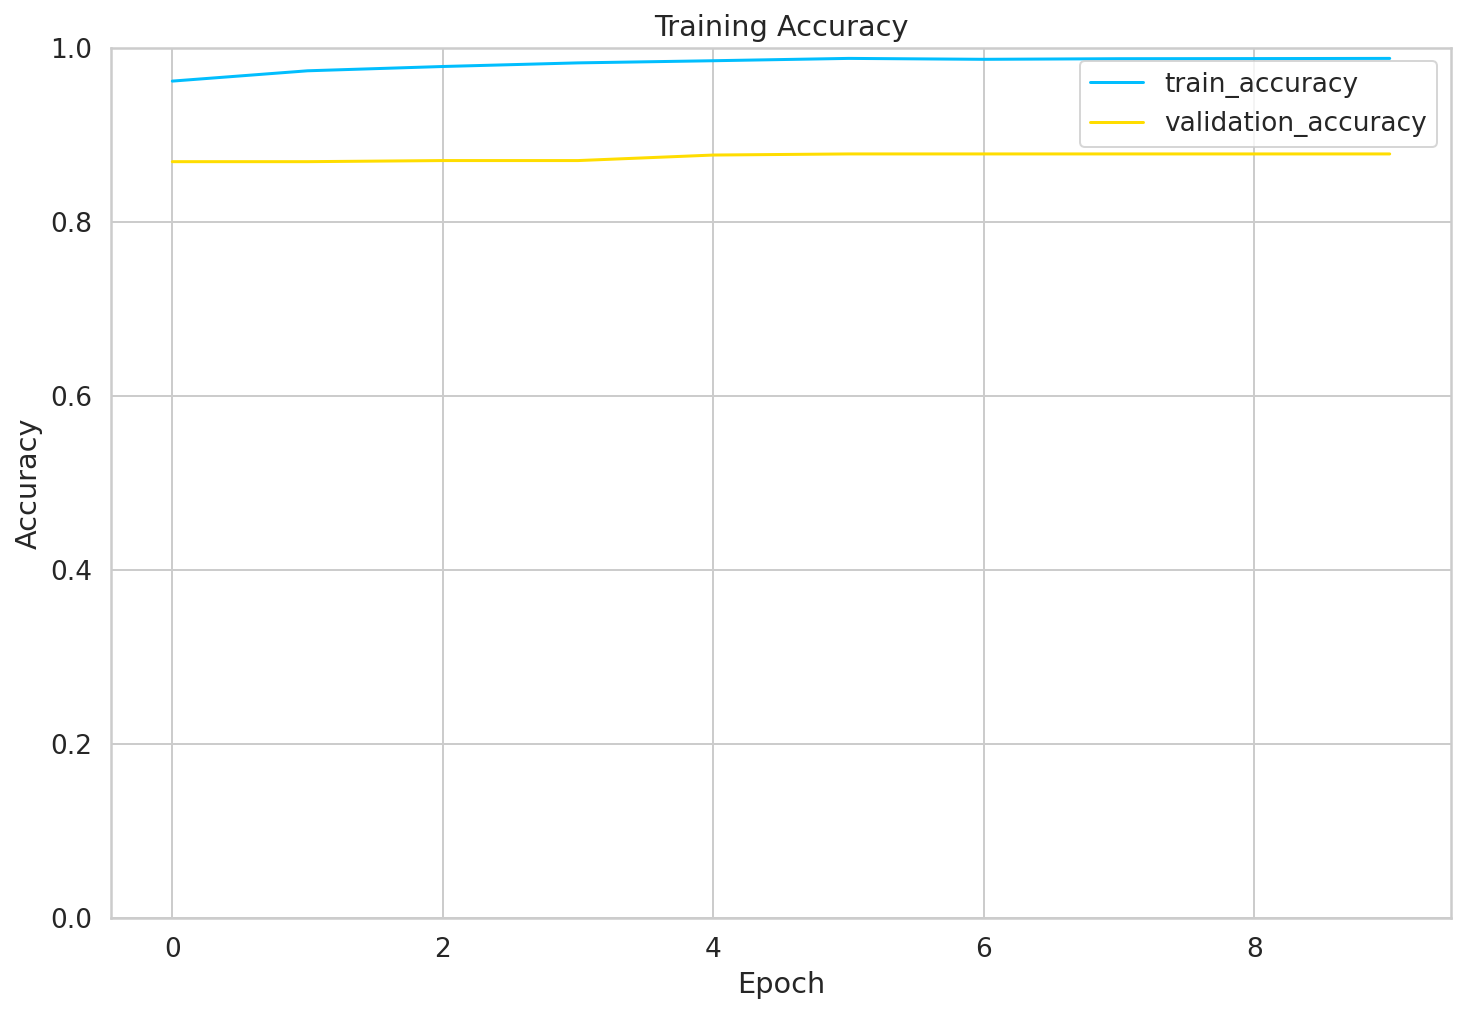

In [ ]:
plt.plot(history['train_acc'],label='train_accuracy')
plt.plot(history['val_acc'], label='validation_accuracy')

plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.ylim([0,1])

In [ ]:
test_acc,_=eval_model(model,test_data_loader,loss_fn,device,len(df_test))
test_acc.item()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

0.8946700507614213

In [ ]:
def get_predictions(model,data_loader):
  model=model.eval()
  review_texts=[]
  predictions=[]
  prediction_probs=[]
  real_values=[]

  with torch.no_grad():
    for d in data_loader:
      texts=d['review_text']
      input_ids=d['input_ids'].to(device)
      attention_mask=d['attention_mask'].to(device)
      targets=d['targets'].to(device)
      outputs=model(input_ids=input_ids,attention_mask=attention_mask)
      _,preds=torch.max(outputs,dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions=torch.stack(predictions).cpu()
  prediction_probs=torch.stack(prediction_probs).cpu()
  real_values=torch.stack(real_values).cpu()
  return review_texts,predictions,prediction_probs,real_values

In [ ]:
y_review_texts,y_pred,y_pred_probs,y_test=get_predictions(model,test_data_loader)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [ ]:
print(classification_report(y_test,y_pred,target_names=class_names))

              precision    recall  f1-score   support

    negative       0.93      0.86      0.90       245
     neutral       0.84      0.89      0.86       254
    positive       0.91      0.93      0.92       289

    accuracy                           0.89       788
   macro avg       0.90      0.89      0.89       788
weighted avg       0.90      0.89      0.89       788



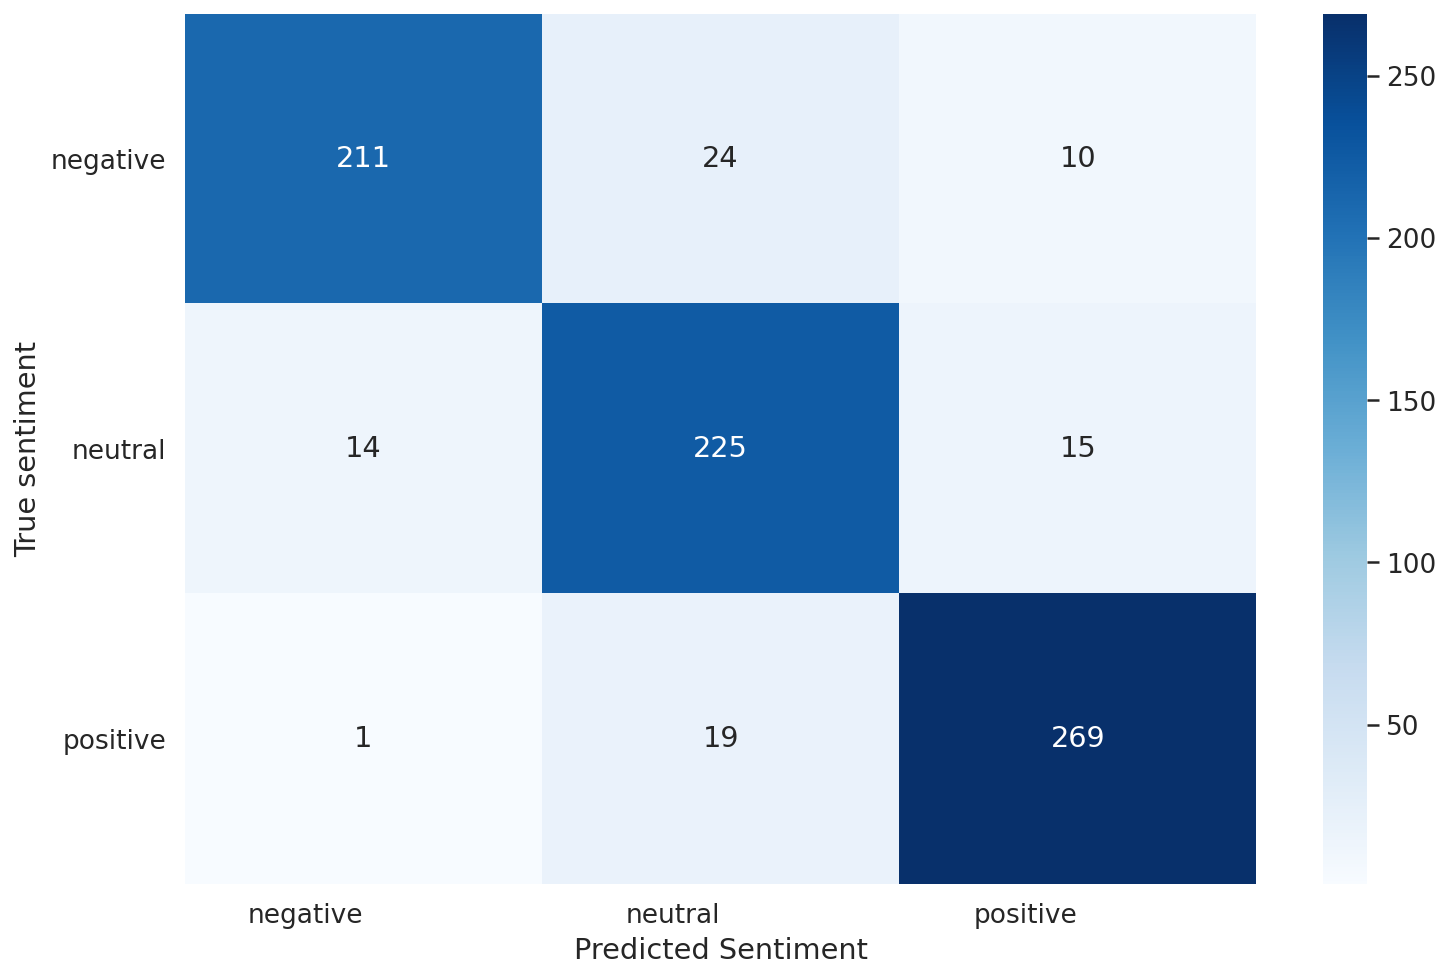

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap=sns.heatmap(confusion_matrix,annot=True,fmt='d',cmap='Blues')
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(),rotation=0,ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(),rotation=0,ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted Sentiment')
cm=confusion_matrix(y_test,y_pred)
df_cm=pd.DataFrame(cm,index=class_names,columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx=2
review_text=y_review_texts[idx]
true_sentiment=y_test[idx]
pred_df=pd.DataFrame({'class_names':class_names,'values':y_pred_probs[idx]})


In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True Sentiment: {class_names[true_sentiment]}')

I used to use Habitica, and I must say this is a great step up. I'd
like to see more social features, such as sharing tasks - only one
person has to perform said task for it to be checked off, but only
giving that person the experience and gold. Otherwise, the price for
subscription is too steep, thus resulting in a sub-perfect score. I
could easily justify $0.99/month or eternal subscription for $15. If
that price could be met, as well as fine tuning, this would be easily
worth 5 stars.

True Sentiment: neutral


(0.0, 1.0)

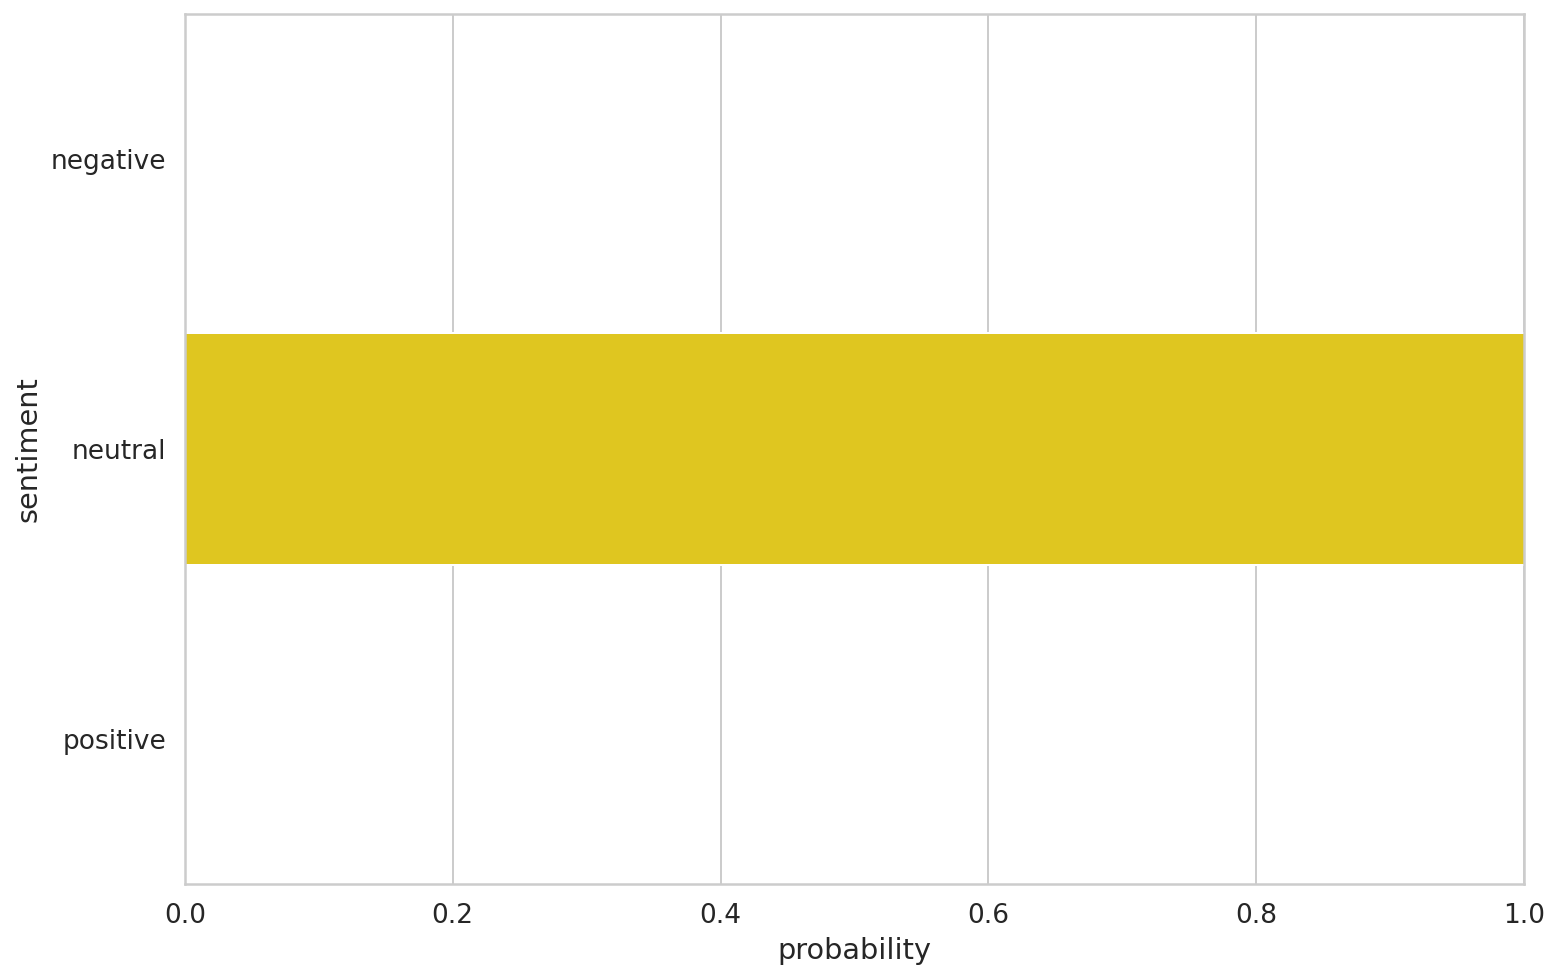

In [ ]:
sns.barplot(x='values',y='class_names',data=pred_df,orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0,1])

In [ ]:
def custom_testing(review_text):
  encoded_review=tokenizer.encode_plus(review_text,
                                      max_length=MAX_LEN,
                                      add_special_tokens=True,
                                      return_token_type_ids=False,
                                      padding=True,
                                      return_attention_mask=True,
                                      truncation=True,
                                      return_tensors='pt')
  input_ids=encoded_review['input_ids'].to(device)
  attention_mask=encoded_review['attention_mask'].to(device)
  output=model(input_ids,attention_mask)
  _,prediction=torch.max(output,dim=1)
  print(f'Review text: {review_text}')
  print(f'Sentiment: {class_names[prediction]}')

In [ ]:
review_text=input()
custom_testing(review_text)

its fairly good and awesome but bad
Review text: its fairly good and awesome but bad
Sentiment: neutral


Review text: I love completing my todos! Best app ever!!!
Sentiment: positive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!sudo cp /content/best_model_state.bin F'/content/gdrive/My Drive/ML_MODELS/BERT'

cp: cannot stat '/content/best_model_state.bin': No such file or directory


In [ ]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))